In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy
import torchvision
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset
from google.colab import files

In [0]:
train_x_64 = []
train_y_64 = []

train_x_32 = []
train_y_32 = []

for i in range(1, 101, 1):
    temperature = "{:.2f}".format(0.01 * i)
    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    y_output = np.asarray([u,v,pressure])
    x_input = np.asarray([u,v,pressure])
    train_x_64.append(x_input)
    train_y_64.append(y_output)
    
    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)    
    
    y_output = np.asarray([u,v,pressure])
    x_input = np.asarray([u,v,pressure])
    
    train_x_32.append(x_input)
    train_y_32.append(y_output)

In [0]:
val_x_32 = []
val_y_32 = []

val_x_64 = []
val_y_64 = []

for i in range(1, 20, 2):
    temperature = 0.05 * i + 0.005
    temperature = "{:.3f}".format(temperature)
    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)

    x_input = np.asarray([u,v,pressure])
    y_output = np.asarray([u,v,pressure])
   
    val_x_64.append(x_input)
    val_y_64.append(y_output)
    
    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    y_output = np.asarray([u,v,pressure])
    x_input = np.asarray([u,v,pressure])
    
    val_x_32.append(x_input)
    val_y_32.append(y_output)
    
    
    temperature = 0.05 * i - 0.005
    temperature = "{:.3f}".format(temperature)
    
    file_path = '64_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '64_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '64_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '64_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    x_input = np.asarray([u,v,pressure])
    y_output = np.asarray([u,v,pressure])

    val_x_64.append(x_input)
    val_y_64.append(y_output)

    file_path = '32_u_' + str(temperature) + '.txt'
    u = np.loadtxt(file_path)
    
    file_path = '32_v_' + str(temperature) + '.txt'
    v = np.loadtxt(file_path)
    
    file_path = '32_vel_' + str(temperature) + '.txt'
    vel = np.loadtxt(file_path)
    
    file_path = '32_pressure_' + str(temperature) + '.txt'
    pressure = np.loadtxt(file_path)
    
    x_input = np.asarray([u,v,pressure])
    y_output = np.asarray([u,v,pressure])
    
    val_x_32.append(x_input)
    val_y_32.append(y_output)

In [0]:
class dataset(Dataset):
    def __init__(self, train_x, train_y):
        self.x = train_x
        self.y = train_y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
      
data_32 = dataset(train_x_32, train_y_32)
data_64 = dataset(train_x_64, train_y_64)
val_32 = dataset(val_x_32, val_y_32)
val_64 = dataset(val_x_64, val_y_64)

In [0]:
def show(image):
    plt.imshow(image, vmin=np.amin(image), vmax=np.amax(image), cmap='hsv')
    plt.axis('off')
    plt.show()

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class UnFlatten(nn.Module):
    def forward(self, input):
        input = input.view(1, 3, 24, 24)
        return input

class auto_encoder_high_res(nn.Module):
  def __init__(self):
    super(auto_encoder_high_res, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),

        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        Flatten()
    )
    
    self.fc1 = nn.Sequential(
        nn.Linear(1728, 1728),
        nn.Tanh()
    )
    
    self.decoder = nn.Sequential(
        
        UnFlatten(),
        
        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),

        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),

        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),
        
        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),     
    )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    x = self.decoder(x)
    return x
  
  def downsample(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x
  
  def upsample(self, x):
    x = self.decoder(x)
    return x

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class UnFlatten(nn.Module):
    def forward(self, input):
        input = input.view(1, 3, 24, 24)
        return input

class auto_encoder_low_res(nn.Module):
  def __init__(self):
    super(auto_encoder_low_res, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3),

        Flatten()
    )
    
    self.fc1 = nn.Sequential(
        nn.Linear(1728, 1728),
        nn.Tanh()
    )    
    
    self.decoder = nn.Sequential(
        
        UnFlatten(),
        
        nn.ConvTranspose2d(in_channels = 3, out_channels = 3, kernel_size = 9, stride = 1, padding = 0, output_padding = 0),
        nn.Tanh(),
        nn.BatchNorm2d(3)        
    )
    
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    x = self.decoder(x)
    return x
  
  def downsample(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x
  
  def upsample(self, x):
    x = self.decoder(x)
    return x

In [0]:
class fnn(nn.Module):
  def __init__(self):
    super(fnn, self).__init__()
    self.encode = nn.Sequential(
      nn.BatchNorm1d(1),  
      nn.Linear(1728, 1728),
      nn.BatchNorm1d(1),  
      nn.Linear(1728,1728),  
      nn.Tanh()
    )
  def forward(self,x):
    return self.encode(x)    

In [0]:
import torch.nn as nn
import torch.nn.init as init

M = 0.01
sdev = 0.001

def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=M, std=sdev)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=M, std=sdev)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=M, std=sdev)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [0]:
train_loader_64 = torch.utils.data.DataLoader(data_64, batch_size = 1, shuffle = False)
train_loader_32 = torch.utils.data.DataLoader(data_32, batch_size = 1, shuffle = False)
test_loader_64 = torch.utils.data.DataLoader(val_64, batch_size = 1, shuffle = False)
test_loader_32 = torch.utils.data.DataLoader(val_32, batch_size = 1, shuffle = False)

In [0]:
high_res = auto_encoder_high_res()
high_res = high_res.double()
high_res = high_res.cuda()
low_res = auto_encoder_low_res()
low_res = low_res.double()
low_res = low_res.cuda()
inter = fnn()
inter = inter.double()
inter = inter.cuda()
path = "weights_1.pth"
high_res.load_state_dict(torch.load(path))
path = "weights_2.pth"
low_res.load_state_dict(torch.load(path))
'''
path = "weights_3.pth"
inter.load_state_dict(torch.load(path))
'''

'\npath = "weights_3.pth"\ninter.load_state_dict(torch.load(path))\n'

In [0]:
train_loader_64 = torch.utils.data.DataLoader(data_64, batch_size = 1, shuffle = False)

embed_64 = []

for i, dat in enumerate((train_loader_64), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 3, 64, 64)
        labels = labels.resize_(1, 3, 64, 64)
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = high_res.downsample(inputs)
        embed_64.append(outputs[0].cpu().detach().numpy())
        
embed_64 = np.asarray(embed_64)        

In [0]:
train_loader_32 = torch.utils.data.DataLoader(data_32, batch_size = 1, shuffle = False)

embed_32 = []

for i, dat in enumerate((train_loader_32), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 3, 32, 32)
        labels = labels.resize_(1, 3, 32, 32)
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = low_res.downsample(inputs)
        embed_32.append(outputs[0].cpu().detach().numpy())

embed_32 = np.asarray(embed_32)        

In [0]:
linear_data = dataset(embed_32, embed_64)

In [0]:
inter.apply(weight_init)

fnn(
  (encode): Sequential(
    (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1728, out_features=1728, bias=True)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1728, out_features=1728, bias=True)
    (4): Tanh()
  )
)

In [0]:
learning_rate = 0.00005
optimizer = optim.Adam(inter.parameters(), lr = learning_rate, weight_decay = 1e-5)
criterion = nn.MSELoss()

In [0]:
embed_loader = torch.utils.data.DataLoader(linear_data, batch_size = 1, shuffle = False)

running_loss = 0.0
num_epochs = 1001

for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss = 0.0
    for i, dat in enumerate((embed_loader), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 1, 1728)
        labels = labels.resize_(1, 1, 1728)
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = inter(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss/=100.0
    print("Epoch: ",epoch+1,"running_loss: ",running_loss*100)

Epoch:  1 running_loss:  0.005180668393352662
Epoch:  2 running_loss:  0.004545217418878165
Epoch:  3 running_loss:  0.004468010845710562
Epoch:  4 running_loss:  0.0044340839729488405
Epoch:  5 running_loss:  0.004099624440963735
Epoch:  6 running_loss:  0.0038543513271238573
Epoch:  7 running_loss:  0.003655729236117429
Epoch:  8 running_loss:  0.003607296530229558
Epoch:  9 running_loss:  0.003686741383134232
Epoch:  10 running_loss:  0.0035595880386894633
Epoch:  11 running_loss:  0.003404418256029867
Epoch:  12 running_loss:  0.0033330099867721476
Epoch:  13 running_loss:  0.00324163015560583
Epoch:  14 running_loss:  0.003249202649354822
Epoch:  15 running_loss:  0.0030072865608897098
Epoch:  16 running_loss:  0.0029005614222850436
Epoch:  17 running_loss:  0.0028564944121175395
Epoch:  18 running_loss:  0.0028104072161416085
Epoch:  19 running_loss:  0.002737899339805048
Epoch:  20 running_loss:  0.0027113350486586943
Epoch:  21 running_loss:  0.002677828651268299
Epoch:  22 run

KeyboardInterrupt: ignored

In [0]:
torch.save(inter.state_dict(), "weights_3.pth")
files.download("weights_3.pth")

In [0]:
output_embed_64 = []

for i, dat in enumerate((embed_loader), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 1, 1728)
        labels = labels.resize_(1, 1, 1728)
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = inter(inputs)
        output_embed_64.append(outputs[0][0].cpu().detach().numpy())

output_embed_64 = np.asarray(output_embed_64)        

In [0]:
final_data = dataset(embed_64, embed_64)

final_loader = torch.utils.data.DataLoader(final_data, batch_size = 1, shuffle = False)

final_output = []

for i, dat in enumerate((final_loader), 0):
        inputs, labels = dat
        inputs = inputs.resize_(1, 1, 1728)
        labels = labels.resize_(1, 1, 1728)
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = high_res.upsample(inputs)
        
        final_output.append(outputs[0].cpu().detach().numpy())

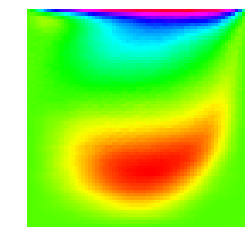

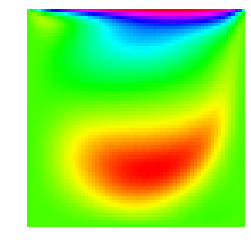

In [0]:
show(final_output[50][0])
show(train_y_64[50][0])

In [0]:
L2_loss = 0.0

for i in range(100):
  L2_loss += np.linalg.norm(train_x_64[i][0]-final_output[i][0])

print(L2_loss)  

26.962595506731297
